In [1]:
import pandas as pd

vegas = pd.read_csv('data/tiles_Vegas.csv', index_col=0)
paris = pd.read_csv('data/tiles_Paris.csv', index_col=0)
shanghai = pd.read_csv('data/tiles_Shanghai.csv', index_col=0)
khartoum = pd.read_csv('data/tiles_Khartoum.csv', index_col=0)

df = pd.concat([vegas, paris, shanghai, khartoum]).reset_index()
df

df_20cities = pd.read_csv('data/20cities_dataset.csv', index_col=0)

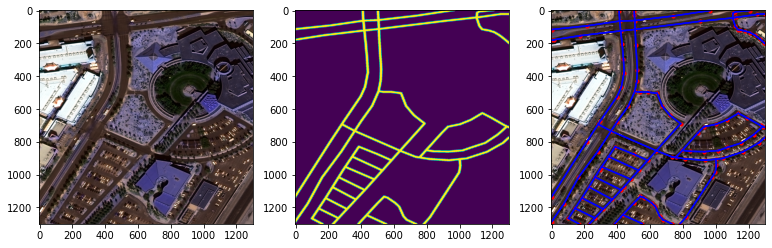

In [2]:
import pickle

from collections import defaultdict

import cv2
import numpy as np
import pylab as plt


def to_int(u):
    return min(int(u[1]), 1299), min(int(u[0]), 1299)


def load_graph(path):
    graph = defaultdict(set)
    for u, neighbours in pickle.load(open(path, 'rb')).items():
        u = to_int(u)
        for v in neighbours:
            graph[u].add(to_int(v))
    return graph


tile = cv2.imread(df.loc[0, 'tile'])
mask = cv2.imread(df.loc[0, 'mask'], cv2.cv2.IMREAD_GRAYSCALE).reshape((1300, 1300, 1))
graph = load_graph(df.loc[0, 'graph'])


def plot_graph(ax, graph, background):
    ax.imshow(background)
    for u, neighbours in graph.items():
        for v in neighbours:
            ax.plot((u[1], v[1]), (u[0], v[0]), color='b')
    for y, x in graph.keys():
        ax.scatter(x, y, color='r', s=10)

            
fig, ax = plt.subplots(1, 3, figsize=(13, 30))
ax[0].imshow(tile)
ax[1].imshow(mask)
plot_graph(ax[2], graph, tile)

Text(0.5, 1.0, 'Decoded graph')

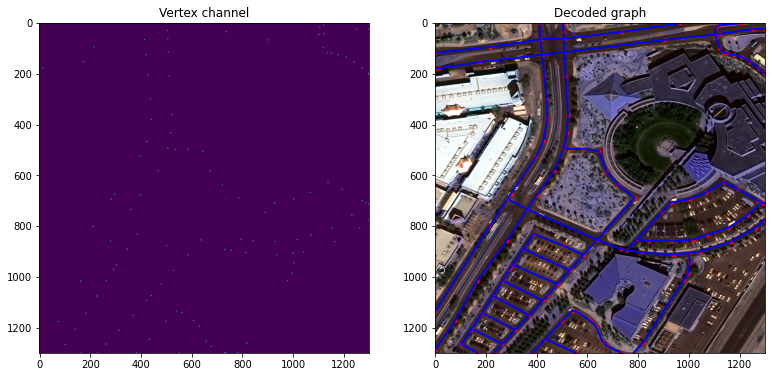

In [3]:
from gte import GraphTensorEncoder

encoder = GraphTensorEncoder(1300, 6, 20)

encoded_graph = encoder.encode(graph)
decoded_graph = encoder.decode(encoded_graph)

fig, ax = plt.subplots(1, 2, figsize=(13, 30))

ax[0].imshow(encoded_graph[:, :, 0])
ax[0].set_title('Vertex channel')

plot_graph(ax[1], decoded_graph, tile)
ax[1].set_title('Decoded graph')

Text(0.5, 1.0, 'Decoded graph')

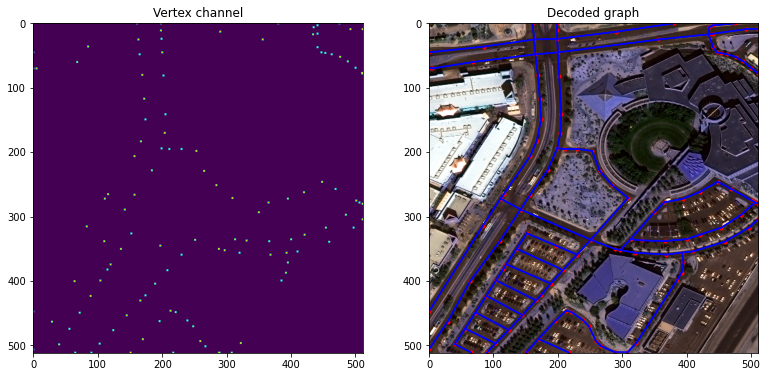

In [4]:
def rescale_point(point, old_image_size, new_image_size):
    x = min(int(point[0] * new_image_size / old_image_size), new_image_size - 1)
    y = min(int(point[1] * new_image_size / old_image_size), new_image_size - 1)
    return x, y


def rescale_graph(graph, old_image_size, new_image_size):
    rescaled_graph = defaultdict(set)
    for u, neighbours in graph.items():
        u = rescale_point(u, old_image_size, new_image_size)
        for v in neighbours:
            v = rescale_point(v, old_image_size, new_image_size)
            rescaled_graph[u].add(v)
    return rescaled_graph
        
encoder = GraphTensorEncoder(512, 6, 20)

encoded_graph = encoder.encode(rescale_graph(graph, 1300, 512))
decoded_graph = encoder.decode(encoded_graph)

fig, ax = plt.subplots(1, 2, figsize=(13, 30))

ax[0].imshow(encoded_graph[:, :, 0])
ax[0].set_title('Vertex channel')

plot_graph(ax[1], decoded_graph, cv2.resize(tile, (512, 512)))
ax[1].set_title('Decoded graph')    

2022-05-15 17:55:13.663481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 17:55:14.251531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13579 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8b:00.0, compute capability: 7.5


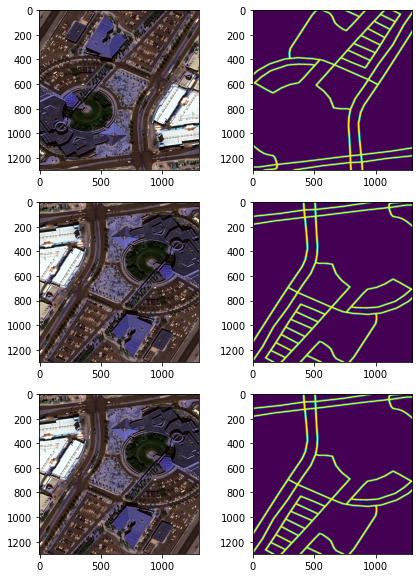

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

class Flip(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_tile = layers.RandomFlip(seed=seed)
        self.augment_mask = layers.RandomFlip(seed=seed)
    
    def call(self, tile, mask):
        tile = self.augment_tile(tile)
        mask = self.augment_mask(mask)
        return tile, mask
        
flip = Flip()

tile_tf = tf.convert_to_tensor(tile, dtype=tf.uint8)
mask_tf = tf.convert_to_tensor(mask, dtype=tf.uint8)

fig, ax = plt.subplots(3, 2, figsize=(7, 10))

for i in range(3):
    flipped_tile_tf, flipped_mask_tf = flip.call(tile_tf, mask_tf)
    ax[i, 0].imshow(flipped_tile_tf.numpy())
    ax[i, 1].imshow(flipped_mask_tf.numpy())

In [6]:
def unstack(tensor, axis=3, image_size=512):
    unstacked_tensors = []
    for i, t in enumerate(tf.unstack(tensor, axis=axis)):
        unstacked_tensors.append(tf.reshape(t, [-1, image_size, image_size, 1]))
    return unstacked_tensors

graph_tensor = tf.convert_to_tensor([encoded_graph])

unstacked = unstack(graph_tensor)
print('-----------------------------')

for i, t in enumerate(unstacked):
    print(f'{i:02d}: {tf.shape(t)}')

-----------------------------
00: [  1 512 512   1]
01: [  1 512 512   1]
02: [  1 512 512   1]
03: [  1 512 512   1]
04: [  1 512 512   1]
05: [  1 512 512   1]
06: [  1 512 512   1]
07: [  1 512 512   1]
08: [  1 512 512   1]
09: [  1 512 512   1]
10: [  1 512 512   1]
11: [  1 512 512   1]
12: [  1 512 512   1]
13: [  1 512 512   1]
14: [  1 512 512   1]
15: [  1 512 512   1]
16: [  1 512 512   1]
17: [  1 512 512   1]
18: [  1 512 512   1]


In [7]:
from tensorflow.keras.metrics import binary_crossentropy

def gt_loss(y_true, y_pred, max_degree=6, image_size=512):
    y_true = unstack(y_true)
    y_pred = unstack(y_pred)
    
#     batch_size = tf.shape(y_pred[0])[0]

#     soft_mask = tf.reshape(y_pred[0], (batch_size, image_size, image_size))
    #  Crossentropy loss for vertex channel
    pv_loss = tf.reduce_mean(binary_crossentropy(y_true[0], y_pred[0]))
    pe_loss = 0
#     for i in range(max_degree):
#         pe_crossentropy = binary_crossentropy(y_true[1 + 3*i], y_pred[1 + 3*i])
#         # Apply only to keypoints!
#         pe_loss += tf.reduce_mean(tf.multiply(soft_mask, pe_crossentropy))
    direction_loss = 0
#     for i in range(max_degree):
#         v1 = tf.concat(y_true[2 + 3*i:4 + 3*i], axis=3)
#         v2 = tf.concat(y_pred[2 + 3*i:4 + 3*i], axis=3)
#         # Apply only to keypoints!
#         direction_loss += tf.reduce_mean(tf.multiply(y_pred[0], tf.square(v2 - v1)))
    return pv_loss + 10 * pe_loss + 1000 * direction_loss

gt_loss(graph_tensor, graph_tensor, image_size=512)

<tf.Tensor: shape=(), dtype=float64, numpy=0.00111236285298225>

In [8]:
class Reader:
    def __init__(self, df, image_size):
        self.encoder = GraphTensorEncoder(max_degree=6, image_size=image_size, d=25)
        self.df = df
        self.image_size = image_size
        
    def __call__(self):
        for index, row in self.df.iterrows():
            tile = cv2.imread(row['tile'])
            graph = load_graph(row['graph'])
            gt = encoder.encode(graph)
            yield tile, gt
            
image_size = (512, 512)
dataset = tf.data.Dataset.from_generator(Reader(df_20cities, image_size),
                                        output_signature=(
                                            tf.TensorSpec(shape=image_size+(3,), dtype=tf.float32),
                                            tf.TensorSpec(shape=image_size+(19,), dtype=tf.float32)
                                        )).cache()\
                                          .batch(8)\
                                          .repeat()\
                                          .prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
import segmentation_models as sm

sm.set_framework('tf.keras')

model = sm.Linknet('resnet50', encoder_weights='imagenet', classes=19)

scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, 3000, 0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss=gt_loss)

model.fit(dataset, epochs=10, steps_per_epoch=500)

Segmentation Models: using `keras` framework.
Epoch 1/10


2022-05-15 17:55:27.127535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200
2022-05-15 17:55:27.610729: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


500/500 [==============================] - 381s 736ms/step - loss: 0.0624
Epoch 2/10
500/500 [==============================] - 387s 774ms/step - loss: 0.0298
Epoch 3/10
500/500 [==============================] - 380s 761ms/step - loss: 0.0294
Epoch 4/10
500/500 [==============================] - 381s 761ms/step - loss: 0.0295
Epoch 5/10
500/500 [==============================] - 381s 761ms/step - loss: 0.0300
Epoch 6/10
500/500 [==============================] - 381s 763ms/step - loss: 0.0295
Epoch 7/10
500/500 [==============================] - 381s 762ms/step - loss: 0.0296
Epoch 8/10
500/500 [==============================] - 381s 762ms/step - loss: 0.0299
Epoch 9/10
500/500 [==============================] - 381s 762ms/step - loss: 0.0300
Epoch 10/10
500/500 [==============================] - 381s 762ms/step - loss: 0.0298


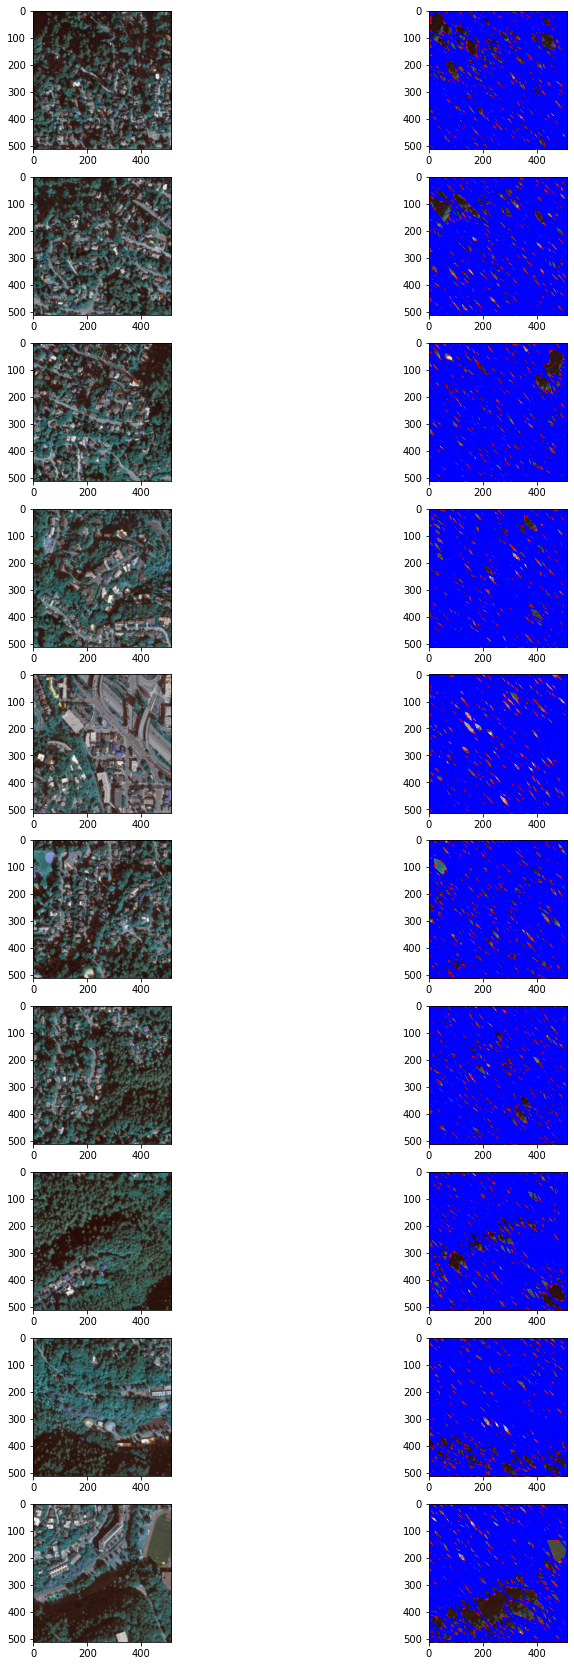

In [10]:
def read_images(df: pd.DataFrame):
    def reader():
        for index, row in df.iterrows():
            yield cv2.imread(row['tile'])
    return reader


import numpy as np
import rtree as rt

from scipy.ndimage import gaussian_filter
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import binary_erosion
from scipy.ndimage import maximum_filter
from scipy.spatial import distance


def _shifts(x, y, radius):
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            yield x + dx, y + dy


class GraphTensorEncoder2:
    def __init__(self, image_size, max_degree, d, pv_threshold=0.5, pe_threshold=0.5):
        self.image_size = image_size
        self.max_degree = max_degree
        self.d = d
        self.radius = 1
        self.pv_threshold = pv_threshold
        self.pe_threshold = pe_threshold
        self.w = 100

    def encode(self, graph):
        encoded = np.zeros((self.image_size, self.image_size, 3 * self.max_degree + 1))

        for (xv, yv) in graph.keys():

            for x, y in _shifts(xv, yv, self.radius):
                #  Probability of having vertex at position (x, y)
                if 0 <= x < self.image_size and 0 <= y < self.image_size:
                    encoded[x, y, 0] = 0.9

            encoded[xv, yv, 0] = 1.0

            for i, (xu, yu) in enumerate(graph[(xv, yv)]):
                dx = xu - xv
                dy = yu - yv

                angle = np.arctan2(dx, dy) * 180 / np.pi + 180  # degrees

                sector = int(angle / (360 / self.max_degree)) % self.max_degree

                for x, y in _shifts(xv, yv, self.radius):
                    if 0 <= x < self.image_size and 0 <= y < self.image_size:
                        #  Probability of having edge from position (x, y) to (x + dx, y + dy)
                        encoded[x, y, 1 + 3 * sector] = 1
                        #  Normalized dx
                        encoded[x, y, 2 + 3 * sector] = dx / self.d
                        #  Normalized dy
                        encoded[x, y, 3 + 3 * sector] = dy / self.d

        return encoded

    def decode(self, encoded):
        vertexes = self._detect_vertexes(gaussian_filter(encoded[:, :, 0], 1, mode='constant'))
        #  Insert vertexes in rtree to speed up queries
        rtree_index = rt.Index()
        for i, (xv, yv) in enumerate(vertexes):
            rtree_index.insert(i, [xv - 1, yv - 1, xv + 1, yv + 1])
        #  Connect vertexes
        graph = {(xv, yv): [] for (xv, yv) in vertexes}
        for i, (xv, yv) in enumerate(vertexes):
            for j in range(self.max_degree):
                pe = encoded[xv, yv, 3*j + 1]
                if pe < self.pe_threshold:
                    continue
                dx = int(encoded[xv, yv, 3*j + 2] * self.d)
                dy = int(encoded[xv, yv, 3*j + 3] * self.d)

                candidates = list(rtree_index.intersection([
                    xv + dx - self.d,
                    yv + dy - self.d,
                    xv + dx + self.d,
                    yv + dy + self.d
                ]))

                min_distance = np.inf
                best_candidate = None

                def dist(xu, yu):
                    v0 = np.array([xv + dx, yv + dy])
                    v1 = np.array([xu, yu])
                    v2 = np.array([xu - xv, yu - yv])
                    v3 = np.array([dx, dy])
                    return distance.euclidean(v0, v1) + self.w * distance.cosine(v2, v3)

                for c in candidates:
                    if c == i:
                        continue
                    current_distance = dist(*vertexes[c])

                    if current_distance < min_distance:
                        min_distance = current_distance
                        best_candidate = c

                if best_candidate is not None:
                    graph[xv, yv].append(vertexes[best_candidate])

        return graph

    def _detect_vertexes(self, vertex_channel):
        neighborhood = generate_binary_structure(len(vertex_channel.shape), 2)

        local_max = (maximum_filter(vertex_channel, footprint=neighborhood) == vertex_channel)

        background = (vertex_channel == 0)

        eroded_background = binary_erosion(
            background, structure=neighborhood, border_value=1)

        detected_maxima = local_max ^ eroded_background
        x, y = np.where((detected_maxima & (vertex_channel > self.pv_threshold)))

        return [(xi, yi) for (xi, yi) in zip(x, y)]


encoder = GraphTensorEncoder2(max_degree=6, image_size=512, d=25, pv_threshold=0.001, pe_threshold=0.001)


tiles = []

reader = read_images(df_20cities.head(10))
for tile in reader():
    tiles.append(tile)
    
tiles = np.array(tiles)
prediction = model.predict(tiles)

fig, ax = plt.subplots(10, 2, figsize=(13, 30))

for i in range(10):
    ax[i, 0].imshow(tiles[i])
    decoded = encoder.decode(prediction[i])
    # print(encoder._detect_vertexes(prediction[i, :, :, 0]))
    plot_graph(ax[i, 1], decoded, tiles[i])

In [11]:
print(np.all(prediction[i, :, :, 0] < 0.1))

True
